# Titanic: Machine Learning from Disaster

### Import Dependencies

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import csv

%matplotlib inline

np.random.seed(1)

## Loading and Preparing Data

In [191]:
data = pd.read_csv('train.csv')
train, test = train_test_split(data, test_size=0.2,random_state=0, stratify=data['label'])

In [187]:
Y_train = train.loc[:, 'label'].as_matrix()
Y_train = np.eye(10)[Y_train].T
X_train = train.loc[:, train.columns != 'label'].as_matrix().T

In [188]:
Y_test = test.loc[:, 'label'].as_matrix()
Y_test = np.eye(10)[Y_test].T
X_test = test.loc[:, test.columns != 'label'].as_matrix().T

In [189]:
X_train = np.multiply(X_train, 1.0/255.0)
X_test = np.multiply(X_test, 1.0/255.0)

In [190]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(784, 33600) (10, 33600)
(784, 8400) (10, 8400)


In [86]:
def get_next_batch(initial, batch_size, X, Y):
    return X[:, initial:initial+batch_size], Y[:, initial:initial+batch_size]

# DNN 

### Initializing parameters with `he initialization`

In [87]:
def Initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    for l in range(1, len(layer_dims)):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2/layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    return parameters

### Activation Functions

In [88]:
def softmax(Z):
    t = np.exp(Z)
    return t / np.sum(t, axis=0)

def relu(Z):
    return np.maximum(0, Z)

### Forward Propogation

In [89]:
def linear_activation_forward(A_prev, W, b, activation):
    Z = np.dot(W, A_prev) + b
    linear_cache = (A_prev, W, b)

    if activation == 'softmax':
        A = softmax(Z)
    elif activation == 'relu':
        A = relu(Z)
        
    activation_cache = Z
    cache = (linear_cache, activation_cache)
#     print('LAF', A.shape)
    return A, cache

In [90]:
def forward_propogation(X, parameters):
    A_prev = X
    L = len(parameters)//2
    caches = []
    for l in range(1, L):
        Wl = parameters['W' + str(l)]
        bl = parameters['b' + str(l)]
        A_prev, cache = linear_activation_forward(A_prev, Wl, bl, 'relu')
        caches.append(cache)

    AL, cache = linear_activation_forward(A_prev, parameters['W' + str(L)], parameters['b' + str(L)], 'softmax')
    caches.append(cache)
    return AL, caches


### Cost Computation

In [110]:
#np.mulliply is diff than X*Y

def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = -1 / m * (np.sum(Y*np.log(AL)))
    cost = np.squeeze(cost)
    return cost

def compute_cost_with_regularization(AL, Y, parameters, lambd):
    m = Y.shape[1]
    cost = 0
    for l in range(1, len(parameters)//2):
        cost += np.sum(np.square(parameters['W' + str(l)]))

    cross_entropy_cost = compute_cost(AL, Y)
    L2_regularization_cost = lambd * cost / (2 * m)

    return  cross_entropy_cost + L2_regularization_cost


### Backward Propogation

In [92]:
def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

In [93]:
def linear_activation_backward(dA, cache, activation):
    
    linear_cache, activation_cache = cache
    
    if activation == 'softmax':
        dZ = dA
    elif activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
        
    A_prev, W, b = linear_cache
    m = A_prev.shape[1]
    dW = 1 / m * np.dot(dZ, A_prev.T)
    db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db


In [94]:
def backward_propogation(AL, Y, caches):
    L = len(caches)
    grads = {}
    dZ = AL - Y
    grads['dA' + str(L)], grads['dW' + str(L)], grads['db' + str(L)] = linear_activation_backward(dZ, caches[L-1], 'softmax')
    A_prev = AL
    for l in range(L-1, 0, -1):
        cache = caches[l-1]
        dA = grads['dA' + str(l+1)]
        dA_prev, dW, db = linear_activation_backward(dA, cache, 'relu')
        grads['dA' + str(l)] = dA_prev
        grads['dW' + str(l)] = dW
        grads['db' + str(l)] = db
        
    return grads

In [156]:
def backward_propogation_with_regularization(AL, Y, caches, lambd):
    L = len(caches)
    grads = {}
    m = Y.shape[1]
    dZ = AL - Y
    grads['dA' + str(L)], grads['dW' + str(L)], grads['db' + str(L)] = linear_activation_backward(dZ, caches[L-1], 'softmax')
    grads['dW' + str(L)] += (lambd * caches[L-1][0][1]) / m
    A_prev = AL

    for l in range(L-1, 0, -1):
        cache = caches[l-1]
        dA = grads['dA' + str(l+1)]
        dA_prev, dW, db = linear_activation_backward(dA, cache, 'relu')
        grads['dA' + str(l)] = dA_prev
        grads['dW' + str(l)] = dW + (lambd * cache[0][1]) / m
        grads['db' + str(l)] = db
        
    return grads

### Updating parameters

In [96]:
def update_parameters(parameters, grads, learning_rate):
    for l in range(1, len(parameters)//2 + 1 ):
        parameters['W' + str(l)] -= learning_rate * grads['dW' + str(l)]
        parameters['b' + str(l)] -= learning_rate * grads['db' + str(l)]
    return parameters

### Building the model

In [171]:
def the_model(X_train, Y_train, layers_dims, learning_rate, num_iterations, lambd):
    costs = []
    initial = 0
    batch_size = 1000
    parameters = Initialize_parameters_deep(layers_dims)

    for i in range(num_iterations+1):
        X, Y = get_next_batch(initial, batch_size, X_train, Y_train)
#         print(initial, X.shape, Y.shape)
        initial = 0 if initial>=33000 else initial+batch_size
#         print(initial)
        AL, caches = forward_propogation(X, parameters)
        if lambd == 0:
            cost = compute_cost(AL, Y)
            grads = backward_propogation(AL, Y, caches)
        else:
            cost = compute_cost_with_regularization(AL, Y, parameters, lambd)
            grads = backward_propogation_with_regularization(AL, Y, caches, lambd)
            
        parameters = update_parameters(parameters, grads, learning_rate)
        if (i%500==0):
            print('Cost at iteration %s is %s' %(i, cost))

        costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per 10000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    np.save("parameters", parameters)
    return parameters


# Training the model

Cost at iteration 0 is 2.38761195804
Cost at iteration 500 is 0.0552477180694
Cost at iteration 1000 is 0.0221190483416
Cost at iteration 1500 is 0.00923716052476
Cost at iteration 2000 is 0.00684658077162


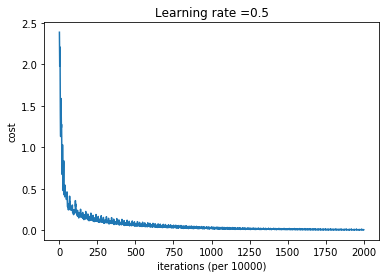

CPU times: user 6min 3s, sys: 38min 44s, total: 44min 48s
Wall time: 1min 7s


In [225]:
%%time
layers_dims = [784, 128, 64, 10]
learning_rate = 0.5
num_iterations = 2001
lambd = 0
parameters = the_model(X_train, Y_train, layers_dims, learning_rate, num_iterations, lambd)

## Accuracy Prediction

In [172]:
def accuracy(X, Y, parameters):
    Y_hat, _ = forward_propogation(X, parameters)
    m = Y.shape[1]
    acc = np.sum(np.argmax(Y, axis=0) == np.argmax(Y_hat, axis=0)) / m
    return acc

In [226]:
%%time
accuracy(X_train, Y_train, parameters)

CPU times: user 191 ms, sys: 102 ms, total: 293 ms
Wall time: 310 ms


0.99970238095238095

In [227]:
%%time
accuracy(X_test, Y_test, parameters)

CPU times: user 11 ms, sys: 21.3 ms, total: 32.3 ms
Wall time: 70.9 ms


0.96857142857142853

# Evaluation Time!

In [165]:
X_test_data = pd.read_csv('test.csv')
X_test_data = np.multiply(X_test_data, 1.0/255.0).T

In [228]:
Y, _ = forward_propogation(X_test_data, parameters)
Y = np.argmax(Y, axis=0)
with open('submission-nn-v1.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(['ImageId', 'Label'])
    for i in range(Y.shape[0]):
        writer.writerow([i+1, Y[i]])

print("Done Writing")

Done Writing
